## PROBLEM SET 1 - TAKE AT HOME (25 POINTS)

**You will lose all corresponding points if we can't access the implementation notebook URL or the Github URL. We will NOT message you. Do NOT invite the TAs to your Github repo (option 2 below) EARLIER than the morning of the day of the exam, since invites expire in 7 days.** 

## Introduction

In the last few years, the field of generative modeling has seen a lot of progress. The techniques that have been developed in this field are very useful for other tasks such as semi-supervised learning, representation learning, and reinforcement learning. In this problem statement we attempt to prepare you to understand the basics of a technique that has been very successful in generative modeling: Variational Autoencoders (VAEs). Understanding VAEs is  the key for you to get a head start with more advanced models such as [Stable Diffusion that are all the rage these days](https://clipdrop.co/stable-diffusion-turbo). 



## Task 1: Study what VAEs are and how they work (0 points)

Consult this [blog post](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/) and its [2D VAE autoencoder implemenation for the MNIST dataset](https://github.com/jaanli/variational-autoencoder). 

## Task 2: Replicate the VAE for the MNIST dataset (25 points)

Implement the VAE model for the MNIST dataset and train it ensuring that you plot the loss curves for the training and validation sets and perform hyperparameter optimization on the size of the latent space as well as on the optimizer parameters. To all points you need to include as comments in the code or as markdown cells what each function in the code is doing. Don't be frugal in your commentary. (15 points)

Replicate the figure showing the final latent variable space shown below. Note that you will not produce the animated figure shown below but show only the final latent space $(z_1, z_2)$. (5 points)

Show VAE generated images for all digits 0-9 after model training. (5 points)

![](latent-variables.gif)

You have two implementation options: (1) All in one notebook (2) Github repo. 

### Option 1: All in one Colab notebook

You submit a single Colab notebook URL that contains all the code and the outputs. Your notebook should be self-contained and can be launched in Google Colab using a corresponding button at the top of the notebook. See the regression notebook in the course site for an example of such button. You **need to save all outputs in the notebook** so that the TAs can check that your code is working properly. 

### Option 2: Github repo 

If you prefer to work without notebooks, with containers or not, you can submit the implementation python scripts and version control your code in a private Github repo. You have to submit the Github URL and clearly document the way to launch the runtime / install requirements.txt and include all required figures in the README.md file. 

IMPORTANT: Ensure that the github repo remains private. If you submit a public github repo you will be held responsible for violating the honor code.

In [1]:
#Import Libraries and files
import os
import numpy as np
import random
import time

import torch
import torch.utils
import torch.utils.data
from torch import nn

import data
import flow
import argparse
import pathlib
import matplotlib.pyplot as plt
import optuna

c:\Users\jason\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [55]:
if not os.path.exists('data'):
   os.makedirs('data')

### 1. set parameters

In [31]:
#Setting parameters
seed = 582838 #random seed
DATA_SIZE = 784 #Input data size, mnist image=28*28=784
FLOW_DEPTH = 2 #Number of layers of Inverse Autoregressive Flows & reversing layer in flow inference
DATA_DIR = "data/" #Directory to save dataset
TRAIN_DIR = "train/" #Directory to save the best model
BATCH_SIZE = 32 #Training batch size
TEST_BATCH_SIZE = 128 #Validate & test batch size
USE_GPU = True #gpu usage
MAX_ITERATIONS = 30000 #Total training steps
N_SAMPLES = 1000 #samples used in evaluation
LOG_INTERVAL = 1000 #log every 1000 steps

### 2. Decoder

In [3]:
class Model(nn.Module):
    """Variational autoencoder, parameterized by a generative network."""

    def __init__(self, latent_size, data_size):
        super().__init__()
        self.register_buffer("p_z_loc", torch.zeros(latent_size)) #mean parameter for Gaussian probability density
        self.register_buffer("p_z_scale", torch.ones(latent_size)) #standard deviation 
        self.log_p_z = NormalLogProb() #Gaussian distribution
        self.log_p_x = BernoulliLogProb() #Bernoulli distribution
        self.generative_network = NeuralNetwork(
            input_size=latent_size, output_size=data_size, hidden_size=latent_size * 2
        ) # decoder

    def forward(self, z, x):
        """Return log probability of model."""
        log_p_z = self.log_p_z(self.p_z_loc, self.p_z_scale, z).sum(-1, keepdim=True) #get log p(z)
        logits = self.generative_network(z) #outputs 784 Bernoulli parameters, one for each of the 784 pixels in the image
        # unsqueeze sample dimension
        logits, x = torch.broadcast_tensors(logits, x.unsqueeze(1))
        log_p_x = self.log_p_x(logits, x).sum(-1, keepdim=True) #get log p(x)
        return log_p_z + log_p_x #Return log p(x, z)


### 3. Encoder

In [4]:
class VariationalMeanField(nn.Module):
    """Approximate posterior parameterized by an inference network."""

    def __init__(self, latent_size, data_size):
        super().__init__()
        self.inference_network = NeuralNetwork(
            input_size=data_size,
            output_size=latent_size * 2,
            hidden_size=latent_size * 2,
        )#Neural network: input is a datapoint x, its output parameter loc and scale
        self.log_q_z = NormalLogProb() #Guassin distribution
        self.softplus = nn.Softplus() #Softplus(x) = 1/β∗log(1+exp(β∗x))

    def forward(self, x, n_samples=1):
        """Return sample of latent variable and log prob."""
        loc, scale_arg = torch.chunk(
            self.inference_network(x).unsqueeze(1), chunks=2, dim=-1
        )# get loc & scale
        scale = self.softplus(scale_arg) 
        eps = torch.randn((loc.shape[0], n_samples, loc.shape[-1]), device=loc.device)
        z = loc + scale * eps  # reparameterization 
        log_q_z = self.log_q_z(loc, scale, z).sum(-1, keepdim=True) #variational posterior: log q(z∣x) 
        return z, log_q_z



In [5]:
class VariationalFlow(nn.Module):
    """Approximate posterior parameterized by a flow (https://arxiv.org/abs/1606.04934)."""

    def __init__(self, latent_size, data_size, flow_depth):
        super().__init__()
        hidden_size = latent_size * 2
        self.inference_network = NeuralNetwork(
            input_size=data_size,
            # loc, scale, and context
            output_size=latent_size * 3,
            hidden_size=hidden_size,
        )
        modules = []
        for _ in range(flow_depth):
            modules.append(
                flow.InverseAutoregressiveFlow(
                    num_input=latent_size,
                    num_hidden=hidden_size,
                    num_context=latent_size,
                )
            )
            modules.append(flow.Reverse(latent_size))
        self.q_z_flow = flow.FlowSequential(*modules)
        self.log_q_z_0 = NormalLogProb()
        self.softplus = nn.Softplus()

    def forward(self, x, n_samples=1):
        """Return sample of latent variable and log prob."""
        loc, scale_arg, h = torch.chunk(
            self.inference_network(x).unsqueeze(1), chunks=3, dim=-1
        )
        scale = self.softplus(scale_arg)
        eps = torch.randn((loc.shape[0], n_samples, loc.shape[-1]), device=loc.device)
        z_0 = loc + scale * eps  # reparameterization
        log_q_z_0 = self.log_q_z_0(loc, scale, z_0)
        z_T, log_q_z_flow = self.q_z_flow(z_0, context=h)
        log_q_z = (log_q_z_0 + log_q_z_flow).sum(-1, keepdim=True)
        return z_T, log_q_z

### 4. Neural Network 

In [6]:
"""Function for creating neural networks in encoder & decoder"""
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()
        modules = [
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        ]
        self.net = nn.Sequential(*modules)

    def forward(self, input):
        return self.net(input)



### 5. Probability Distribution Function

In [7]:
"""Function for Guassion distribution"""
class NormalLogProb(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, loc, scale, z):
        var = torch.pow(scale, 2) #get variance
        return -0.5 * torch.log(2 * np.pi * var) - torch.pow(z - loc, 2) / (2 * var)

In [8]:
"""Function for Bernoulli distribution"""
class BernoulliLogProb(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce_with_logits = nn.BCEWithLogitsLoss(reduction="none")

    def forward(self, logits, target):
        # bernoulli log prob is equivalent to negative binary cross entropy
        return -self.bce_with_logits(logits, target)

In [9]:
""""""
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

### 6. Evaluation Function

In [10]:
@torch.no_grad()
def evaluate(n_samples, model, variational, eval_data):
    model.eval()
    total_log_p_x = 0.0
    total_elbo = 0.0
    for batch in eval_data:
        x = batch[0].to(next(model.parameters()).device) #get x(original data)
        z, log_q_z = variational(x, n_samples) #Encode x to z(latent variables)
        log_p_x_and_z = model(z, x) #Decode
        
        # importance sampling of approximate marginal likelihood with q(z)
        # as the proposal, and logsumexp in the sample dimension
        elbo = log_p_x_and_z - log_q_z #Get ELBO value
        log_p_x = torch.logsumexp(elbo, dim=1) - np.log(n_samples) #logp(x)=ELBO(λ)+KL(q(z∣x)∣∣p(z∣x))
        # average over sample dimension, sum over minibatch
        total_elbo += elbo.cpu().numpy().mean(1).sum()
        # sum over minibatch
        total_log_p_x += log_p_x.cpu().numpy().sum()
    n_data = len(eval_data.dataset)
    return total_elbo / n_data, total_log_p_x / n_data


### 7. Objective function for hyperparameters optimization

In [11]:
def objective(trial):
    device = torch.device("cuda:0" if USE_GPU else "cpu")
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    #Model: hyperparameter optimized:latent variable size
    latent_size = trial.suggest_categorical("latent_size", [16, 32, 64, 128])
    model = Model(latent_size=latent_size, data_size=DATA_SIZE)
    
    #variational: hyperparameter optimized: encoder type, flow depth in flow encoder
    variational = trial.suggest_categorical("variational", ["flow", "mean-field"])
    if variational == "flow":
        variational = VariationalFlow(
            latent_size=latent_size,
            data_size=DATA_SIZE,
            flow_depth=trial.suggest_categorical("flow_depth", [2, 3, 4]),
        )
    elif variational == "mean-field":
        variational = VariationalMeanField(
            latent_size=latent_size, data_size=DATA_SIZE
        )
    model.to(device)
    variational.to(device)
    
    #optimizer: hyperparameter optimized: learning rate
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer = torch.optim.RMSprop(
        list(model.parameters()) + list(variational.parameters()),
        lr=learning_rate,
        centered=True,
    )
    
    #Load dataset
    fname = DATA_DIR + "binary_mnist.h5"
    if not os.path.exists(fname):
        print("Downloading binary MNIST data...")
        data.download_binary_mnist(fname)
    train_data, valid_data, test_data = data.load_binary_mnist(
        fname, BATCH_SIZE, TEST_BATCH_SIZE, USE_GPU
    )
    train_ds = cycle(train_data)
    
    
    #train
    for step in range(MAX_ITERATIONS):
        batch = next(train_ds) #Get 1 batch of data
        x = batch[0].to(device) 
        model.zero_grad()
        variational.zero_grad()
        z, log_q_z = variational(x, n_samples=1) #Encode x to z
        log_p_x_and_z = model(z, x) #Decode z
        # average over sample dimension
        elbo = (log_p_x_and_z - log_q_z).mean(1)
        # sum over batch dimension
        loss = -elbo.sum(0) #Get loss
        loss.backward()
        optimizer.step()
    
    #evaluate
    with torch.no_grad():
        valid_elbo, valid_log_p_x = evaluate(
            N_SAMPLES, model, variational, valid_data
        ) # get Validation ELBO and log p(x)
    return valid_elbo

In [25]:
#Optimize hyperparmaters with Optuna
start_time = time.time()
  
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100) #100 trials
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
print(f"Total time: {(time.time() - start_time) / 60:.2f} minutes")

[I 2023-12-20 02:01:03,946] A new study created in memory with name: no-name-c272e5e7-5d3a-41e8-807f-05aecacfa567
[I 2023-12-20 02:02:25,615] Trial 0 finished with value: -193.649512890625 and parameters: {'latent_size': 128, 'variational': 'mean-field', 'lr': 1.3832023937698829e-05}. Best is trial 0 with value: -193.649512890625.
[I 2023-12-20 02:04:42,037] Trial 1 finished with value: -121.22350541992188 and parameters: {'latent_size': 64, 'variational': 'flow', 'flow_depth': 4, 'lr': 0.0013977707716796596}. Best is trial 1 with value: -121.22350541992188.
[I 2023-12-20 02:06:27,570] Trial 2 finished with value: -157.83904367675783 and parameters: {'latent_size': 64, 'variational': 'flow', 'flow_depth': 2, 'lr': 6.986065122648979e-05}. Best is trial 1 with value: -121.22350541992188.
[I 2023-12-20 02:08:39,187] Trial 3 finished with value: -206.02826328125 and parameters: {'latent_size': 16, 'variational': 'flow', 'flow_depth': 4, 'lr': 1.027087276971826e-05}. Best is trial 1 with va

Number of finished trials: 100
Best trial:
  Value: -112.63242280273437
  Params: 
    latent_size: 128
    variational: mean-field
    lr: 0.0005639888433569298
Total time: 120.10 minutes


In [32]:
"""Function for plotting loss"""
def plot_loss(t_e, v_e, logp):
    #plot loss curve
    plt.title('ELBO & log p(x)')
    plt.xlabel('step(/1000)')
    plt.ylabel('value')
    plt.plot(t_e, color='red', label='Train ELBO')
    plt.plot(v_e, color='green', label='Valid ELBO')
    plt.plot(logp, color='blue', label='Validation log p(x)')
    plt.legend(loc='best')
    plt.savefig('plot/Loss_plot.png')

### 8. Training and testing with optimized hyperparameters

Step 0         	Train ELBO estimate: -556.903	Validation ELBO estimate: -495.609	Validation log p(x) estimate: -474.018	latent variable: (32, 1, 128)	Speed: 1.41e+04 examples/s
Step 1000      	Train ELBO estimate: -172.920	Validation ELBO estimate: -169.581	Validation log p(x) estimate: -160.174	latent variable: (32, 1, 128)	Speed: 1.89e+03 examples/s
Step 2000      	Train ELBO estimate: -143.004	Validation ELBO estimate: -149.109	Validation log p(x) estimate: -138.872	latent variable: (32, 1, 128)	Speed: 1.56e+03 examples/s
Step 3000      	Train ELBO estimate: -133.258	Validation ELBO estimate: -136.457	Validation log p(x) estimate: -127.817	latent variable: (32, 1, 128)	Speed: 1.86e+03 examples/s
Step 4000      	Train ELBO estimate: -124.458	Validation ELBO estimate: -129.412	Validation log p(x) estimate: -121.644	latent variable: (32, 1, 128)	Speed: 1.71e+03 examples/s
Step 5000      	Train ELBO estimate: -110.758	Validation ELBO estimate: -124.826	Validation log p(x) estimate: -117

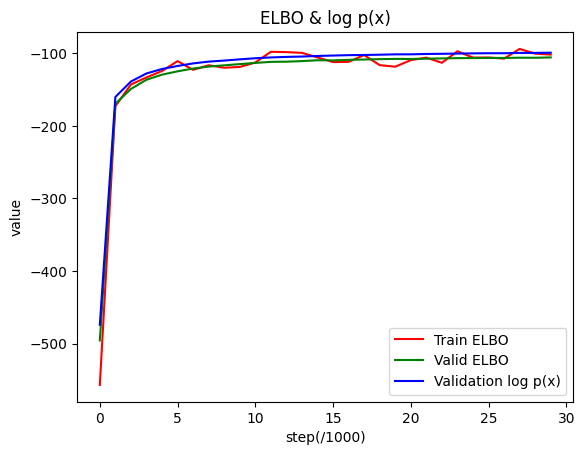

In [35]:
start_time = time.time()
device = torch.device("cuda:0" if USE_GPU else "cpu")
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
    
#Model
latent_size = 128
model = Model(latent_size=latent_size, data_size=DATA_SIZE)
    
#variational
variational = 'mean-field'
if variational == "flow":
    variational = VariationalFlow(
        latent_size=latent_size,
        data_size=DATA_SIZE,
        flow_depth=2,
    )
elif variational == "mean-field":
    variational = VariationalMeanField(
            latent_size=latent_size, data_size=DATA_SIZE
    )
model.to(device)
variational.to(device)
    
#optimizer
learning_rate = 0.000564
optimizer = torch.optim.RMSprop(
    list(model.parameters()) + list(variational.parameters()),
    lr=learning_rate,
    centered=True,
)
    
#dataset
fname = DATA_DIR + "binary_mnist.h5"
if not os.path.exists(fname):
    print("Downloading binary MNIST data...")
    data.download_binary_mnist(fname)
train_data, valid_data, test_data = data.load_binary_mnist(
    fname, BATCH_SIZE, TEST_BATCH_SIZE, USE_GPU
)
train_ds = cycle(train_data)
    
    
#train
t_elbo=[]
v_elbo=[]
v_log=[]
best_valid_elbo = -np.inf 
num_no_improvement = 0
t0 = time.time()

for step in range(MAX_ITERATIONS):
    batch = next(train_ds)
    x = batch[0].to(device)
    model.zero_grad()
    variational.zero_grad()
    z, log_q_z = variational(x, n_samples=1)
    log_p_x_and_z = model(z, x)
    # average over sample dimension
    elbo = (log_p_x_and_z - log_q_z).mean(1)
    # sum over batch dimension
    loss = -elbo.sum(0)
    loss.backward()
    optimizer.step()
    
    if step % LOG_INTERVAL == 0:
            
            t1 = time.time()
            examples_per_sec = LOG_INTERVAL * BATCH_SIZE / (t1 - t0)
            with torch.no_grad():
                valid_elbo, valid_log_p_x = evaluate(
                    N_SAMPLES, model, variational, valid_data
                )
                
            t_elbo.append(round(elbo.detach().cpu().numpy().mean(), 3))
            v_elbo.append(round(valid_elbo, 3))
            v_log.append(round(valid_log_p_x, 3))
        
       
            print(
                f"Step {step:<10d}\t"
                f"Train ELBO estimate: {elbo.detach().cpu().numpy().mean():<5.3f}\t"
                f"Validation ELBO estimate: {valid_elbo:<5.3f}\t"
                f"Validation log p(x) estimate: {valid_log_p_x:<5.3f}\t"
                f"latent variable: {z.detach().cpu().numpy().shape}\t"
                f"Speed: {examples_per_sec:<5.2e} examples/s"
            )
            if valid_elbo > best_valid_elbo:
                num_no_improvement = 0
                best_valid_elbo = valid_elbo
                states = {
                    "model": model.state_dict(),
                    "variational": variational.state_dict(),
                }
                torch.save(states, TRAIN_DIR + "best_state_dict")
            t0 = t1
#evaluate
checkpoint = torch.load(TRAIN_DIR + "best_state_dict")
model.load_state_dict(checkpoint["model"])
variational.load_state_dict(checkpoint["variational"])
test_elbo, test_log_p_x = evaluate(N_SAMPLES, model, variational, test_data)
print(
    f"Step {step:<10d}\t"
    f"Test ELBO estimate: {test_elbo:<5.3f}\t"
    f"Test log p(x) estimate: {test_log_p_x:<5.3f}\t"
)
plot_loss(t_elbo, v_elbo, v_log)
print(f"Total time: {(time.time() - start_time) / 60:.2f} minutes")

### 9. Plotting first and second dimension of the final latent variable

In [52]:
d1 = []
d2 = []
train_data, valid_data, test_data = data.load_binary_mnist(
    fname, 4096, TEST_BATCH_SIZE, USE_GPU
)#get a batch of data
train_ds = cycle(train_data)
batch = next(train_ds)
x = batch[0].to(device)
variational.zero_grad()
z, log_q_z = variational(x, n_samples=1)
latent_variable = z.detach().cpu().numpy()


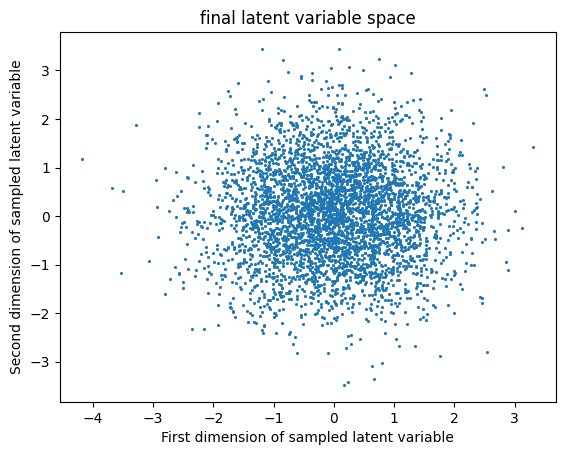

In [54]:
for l in latent_variable:
    d1.append(l[0][0])
    d2.append(l[0][1])
plt.title('final latent variable space') 
plt.xlabel('First dimension of sampled latent variable')       
plt.ylabel('Second dimension of sampled latent variable')          
plt.scatter(np.array(d1), np.array(d2), s=1)
plt.savefig('plot/scatter_plot.png')